In [ ]:
# !pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c8d4fdebaea35dfecf8020b2e7a441cb13b90ee3877039d50393298fafb83fde
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Importing necessary modules
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF

# Importing time module for timing operations
import time

# Importing LinearSVC classifier
from pyspark.ml.classification import LinearSVC

# Importing warnings module to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Importing pandas for data manipulation
import pandas as pd

# Importing IntegerType from pyspark.sql.types for specifying data types
from pyspark.sql.types import IntegerType


# DATA LOADING  





* Load Dataset

In [ ]:
#for access dataset direct through kaggle
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/aksingh2411/dataset-of-malicious-and-benign-webpages?resource=download")

In [ ]:
df_chunk=pd.read_csv("Webpages_Classification_test_data.csv")

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("BDP_PROJECT").getOrCreate()

24/05/06 23:34:28 WARN Utils: Your hostname, Mituls-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.200.10.95 instead (on interface en0)
24/05/06 23:34:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 23:34:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/05/06 23:34:40 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [ ]:
df_spark = spark.createDataFrame(df_chunk)

In [ ]:
df_spark.show()

24/05/06 23:34:47 WARN TaskSetManager: Stage 0 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:34:52 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+----------+--------------------+-------+---------------+-------------+---+----------+-----+------+----------+--------------------+-----+
|Unnamed: 0|                 url|url_len|         ip_add|      geo_loc|tld|    who_is|https|js_len|js_obf_len|             content|label|
+----------+--------------------+-------+---------------+-------------+---+----------+-----+------+----------+--------------------+-----+
|         0|http://www.dutcht...|     36|  175.67.214.68|        China|com|  complete|  yes|  38.5|       0.0|Decay suggest in ...| good|
|         1|http://www.collec...|     32|188.120.171.121|       Sweden|com|incomplete|  yes| 187.0|       0.0|breast addict nud...| good|
|         2|http://www.deadli...|     27|   193.51.170.1|       France|com|  complete|  yes|  31.0|       0.0|Nato's military s...| good|
|         3|http://www.mil.fi...|     56|   13.237.35.44|    Australia| fi|  complete|  yes| 152.0|       0.0|Night being newto...| good|
|         4|http://www.avclub...| 

In [ ]:
# Initializing Column Set
column_set=df_spark.columns
column_set

['Unnamed: 0',
 'url',
 'url_len',
 'ip_add',
 'geo_loc',
 'tld',
 'who_is',
 'https',
 'js_len',
 'js_obf_len',
 'content',
 'label']

# EDA






In [ ]:
df_spark.describe().show()

24/05/06 23:29:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/05/06 23:29:04 WARN TaskSetManager: Stage 1 contains a task of very large size (20721 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+--------------------+------------------+-------------+-----------+------+----------+------+------------------+-----------------+--------------------+------+
|summary|       Unnamed: 0|                 url|           url_len|       ip_add|    geo_loc|   tld|    who_is| https|            js_len|       js_obf_len|             content| label|
+-------+-----------------+--------------------+------------------+-------------+-----------+------+----------+------+------------------+-----------------+--------------------+------+
|  count|           100000|              100000|            100000|       100000|     100000|100000|    100000|100000|            100000|           100000|              100000|100000|
|   mean|          49999.5|                NULL|          35.90026|         NULL|       NULL|  NULL|      NULL|  NULL|119.03937099999997|        7.9497954|                NULL|  NULL|
| stddev|28867.65779668774|                NULL|14.698339101548981|         NULL

### FINDING MISSING VALUES

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# Count missing values in each column
missing_counts = df_spark.select([col(c).isNull().cast("int").alias(c) for c in df_spark.columns]).agg(*[F.sum(c).alias(c) for c in df_spark.columns]).collect()

24/05/06 23:31:47 WARN TaskSetManager: Stage 4 contains a task of very large size (20721 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
from pyspark.sql import Row

# Convert the missing counts list to a Row object
missing_counts_row = Row(*df_spark.columns)

# Create a Row object with the missing counts
missing_counts = missing_counts_row(*missing_counts[0])

# Convert the Row object to a DataFrame
missing_counts_df = spark.createDataFrame([missing_counts])

# Display the missing counts DataFrame
missing_counts_df.show()


+----------+---+-------+------+-------+---+------+-----+------+----------+-------+-----+
|Unnamed: 0|url|url_len|ip_add|geo_loc|tld|who_is|https|js_len|js_obf_len|content|label|
+----------+---+-------+------+-------+---+------+-----+------+----------+-------+-----+
|         0|  0|      0|     0|      0|  0|     0|    0|     0|         0|      0|    0|
+----------+---+-------+------+-------+---+------+-----+------+----------+-------+-----+



###ANALYSIS OF GOOD AND BAD LABELS ACROSS EACH COLUMNS

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when


# Get the list of column names in the DataFrame
columns = df_spark.columns

# Iterate over each column to calculate the count of good and bad labels
for column in columns:
    # Group by column and label, and count the occurrences
    label_analysis = df_spark.groupBy(column, "label").count()

    # Pivot the DataFrame to have separate columns for good and bad counts
    label_analysis_pivot = label_analysis.groupBy(column).pivot("label").sum("count")

    # Rename the columns for better clarity
    label_analysis_pivot = label_analysis_pivot.withColumnRenamed("good", "good_count").withColumnRenamed("bad", "bad_count")

    # Fill NaN values with 0
    label_analysis_pivot = label_analysis_pivot.fillna(0)

    # Sorting the DataFrame by the bad count in descending order
    label_analysis_pivot = label_analysis_pivot.orderBy("bad_count", ascending=False)

    print(f"Analysis for column '{column}' (sorted by bad count in descending order):")
    label_analysis_pivot.show()




Analysis for column 'Unnamed: 0' (sorted by bad count in descending order):
+----------+---------+----------+
|Unnamed: 0|bad_count|good_count|
+----------+---------+----------+
|      3937|        1|         0|
|      7159|        1|         0|
|      7543|        1|         0|
|      2473|        1|         0|
|      3311|        1|         0|
|      2509|        1|         0|
|      1887|        1|         0|
|      8133|        1|         0|
|      2643|        1|         0|
|      3680|        1|         0|
|      2942|        1|         0|
|      3324|        1|         0|
|      2717|        1|         0|
|      6252|        1|         0|
|      1567|        1|         0|
|      6905|        1|         0|
|      1776|        1|         0|
|      7637|        1|         0|
|      8183|        1|         0|
|      2772|        1|         0|
+----------+---------+----------+
only showing top 20 rows

Analysis for column 'url' (sorted by bad count in descending order):
+------------

### GEO-LOCATION ANALYSIS :

* **Determining the Ratio of Good to Bad URLs**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, format_number

# Group by geo_loc and calculate the count of good and bad URLs
geo_loc_analysis = df_spark.groupBy('geo_loc') \
    .agg(count(when(df_spark.label == 'good', True)).alias('good_count'),
         count(when(df_spark.label != 'good', True)).alias('bad_count'))

# Calculate the total count of URLs for each geographical location
geo_loc_analysis = geo_loc_analysis.withColumn('total_count', geo_loc_analysis.good_count + geo_loc_analysis.bad_count)

# Calculate the ratio of good and bad URLs to total URLs for each geographical location
geo_loc_analysis = geo_loc_analysis.withColumn('good_ratio', format_number(geo_loc_analysis.good_count / geo_loc_analysis.total_count, 3)) \
    .withColumn('bad_ratio', format_number(geo_loc_analysis.bad_count / geo_loc_analysis.total_count, 3))

# Sort the DataFrame by the bad count in descending order
geo_loc_analysis = geo_loc_analysis.orderBy('bad_count', ascending=False)

geo_loc_analysis.show()



+--------------+----------+---------+-----------+----------+---------+
|       geo_loc|good_count|bad_count|total_count|good_ratio|bad_ratio|
+--------------+----------+---------+-----------+----------+---------+
| United States|      4237|       81|       4318|     0.981|    0.019|
|         China|       950|       19|        969|     0.980|    0.020|
|         Japan|       578|       14|        592|     0.976|    0.024|
|   South Korea|       285|       10|        295|     0.966|    0.034|
|         India|       107|        8|        115|     0.930|    0.070|
|       Germany|       340|        7|        347|     0.980|    0.020|
|         Italy|       154|        6|        160|     0.963|    0.037|
|        Mexico|        67|        4|         71|     0.944|    0.056|
|        Canada|       208|        4|        212|     0.981|    0.019|
|        Russia|       137|        3|        140|     0.979|    0.021|
|        France|       244|        3|        247|     0.988|    0.012|
|     

* **Exploring Geo Locations with High Incidences of Malicious Labels**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, desc

# Filter the DataFrame to get the list of unique geo_loc values where the bad count is greater than 3
geo_locs_with_bad_count_gt_3 = df_spark.filter(df_spark["label"] != "good").groupBy("geo_loc").agg(count("*").alias("bad_count")).filter("bad_count > 3").select("geo_loc").rdd.map(lambda row: row[0]).collect()

# Iterate over each unique geo_loc with bad count > 3
for geo_loc in geo_locs_with_bad_count_gt_3:
    print(f"Analysis for geo_loc: {geo_loc}")

    # Filter the DataFrame for the specific geo_loc where the label is bad
    geo_loc_bad = df_spark.filter((df_spark["geo_loc"] == geo_loc) & (df_spark["label"] != "good"))

    # Group by other columns and count good and bad labels
    geo_loc_analysis = geo_loc_bad.groupBy("tld", "https").agg(
        count(when(geo_loc_bad["label"] == "good", True)).alias("good_count"),
        count(when(geo_loc_bad["label"] != "good", True)).alias("bad_count")
    )

    # Sort the analysis results in decreasing order of the bad count and show only top 5 counts
    geo_loc_analysis = geo_loc_analysis.orderBy(desc("bad_count")).limit(5)

    geo_loc_analysis.show()



Analysis for geo_loc: Germany
+---+-----+----------+---------+
|tld|https|good_count|bad_count|
+---+-----+----------+---------+
|com|   no|         0|        6|
| it|   no|         0|        1|
+---+-----+----------+---------+

Analysis for geo_loc: United States
+-----+-----+----------+---------+
|  tld|https|good_count|bad_count|
+-----+-----+----------+---------+
|  com|   no|         0|       50|
|  com|  yes|         0|        5|
|   de|   no|         0|        4|
|  net|   no|         0|        4|
|co.uk|   no|         0|        3|
+-----+-----+----------+---------+

Analysis for geo_loc: India
+------+-----+----------+---------+
|   tld|https|good_count|bad_count|
+------+-----+----------+---------+
|   com|   no|         0|        3|
|   net|   no|         0|        1|
|    cz|   no|         0|        1|
|com.ar|   no|         0|        1|
|com.au|   no|         0|        1|
+------+-----+----------+---------+

Analysis for geo_loc: China
+-----+-----+----------+---------+
|  

###TOP LEVEL DOMAIN ANALYSIS :

#### Top 10 TLDs with the Highest Total Counts of Good and Bad URLs

In [ ]:
from pyspark.sql.functions import count, when, desc

# Group by TLD and count good and bad URLs
tld_analysis = df_spark.groupBy("tld").agg(
    count(when(df_spark["label"] == "good", True)).alias("good_urls"),
    count(when(df_spark["label"] != "good", True)).alias("bad_urls")
)

# Calculate the percentage of good and bad URLs
tld_analysis = tld_analysis.withColumn('total_urls', tld_analysis.good_urls + tld_analysis.bad_urls)
tld_analysis = tld_analysis.withColumn(
    "good_percentage", tld_analysis["good_urls"] / (tld_analysis["good_urls"] + tld_analysis["bad_urls"]) * 100
).withColumn(
    "bad_percentage", tld_analysis["bad_urls"] / (tld_analysis["good_urls"] + tld_analysis["bad_urls"]) * 100
)

# Select top 10 TLDs with highest bad percentage
top_bad_tlds = tld_analysis.select("tld", "good_urls",'bad_urls').orderBy(desc("total_urls"))

#The top TLDs with highest bad percentage
top_bad_tlds.show()



+------------+---------+--------+
|         tld|good_urls|bad_urls|
+------------+---------+--------+
|         com|     5783|     129|
|         org|     1245|       7|
|         edu|      560|       0|
|         net|      453|      14|
|       co.uk|      398|       6|
|          ca|      119|       1|
|      com.au|      110|       2|
|      org.uk|       91|       0|
|          de|       71|      13|
|         gov|       73|       0|
|          nl|       64|       2|
|       ac.uk|       62|       0|
|          fr|       42|       4|
|          it|       42|       2|
|        info|       34|       0|
|blogspot.com|       32|       0|
|       co.nz|       27|       0|
|          cz|       22|       1|
|          ch|       21|       1|
|          us|       19|       1|
+------------+---------+--------+
only showing top 20 rows



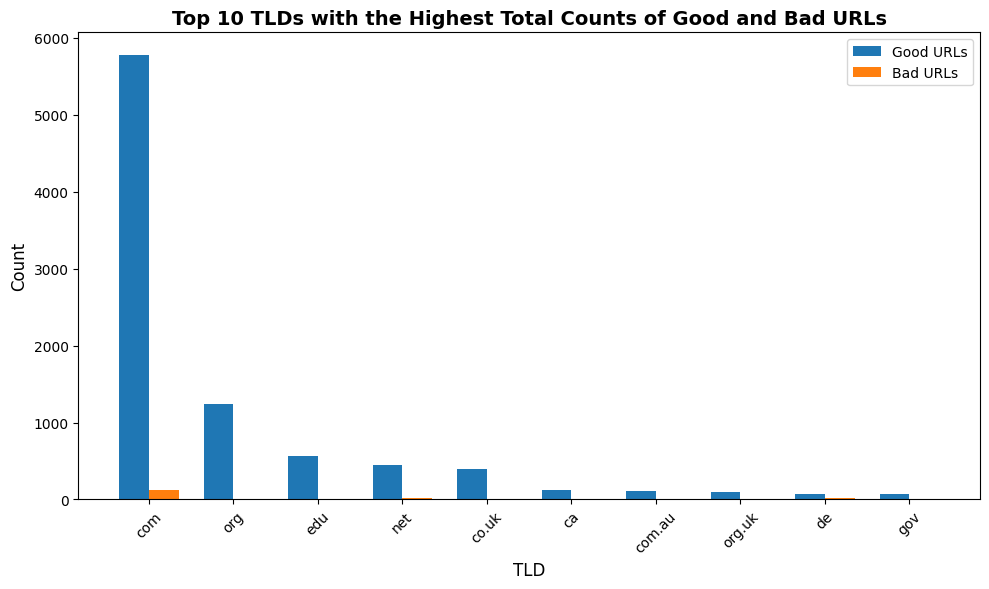

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
top_bad_tlds_pandas = top_bad_tlds.limit(10).toPandas()

# Plotting
plt.figure(figsize=(10, 6))

# Number of TLDs
num_tlds = len(top_bad_tlds_pandas)

# Width of each bar
bar_width = 0.35

# X locations for the groups
index = range(num_tlds)

# Plot bars for good URLs
plt.bar(index, top_bad_tlds_pandas['good_urls'], bar_width, label='Good URLs')

# Plot bars for bad URLs
plt.bar([i + bar_width for i in index], top_bad_tlds_pandas['bad_urls'], bar_width, label='Bad URLs')

# Customizing the plot
plt.xlabel('TLD', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 10 TLDs with the Highest Total Counts of Good and Bad URLs', fontsize=14, fontweight='bold')
plt.xticks([i + bar_width / 2 for i in index], top_bad_tlds_pandas['tld'], rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


####Top TLD'S With Highest Percentage Of Good URLs

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when


# Group by TLD and count good and bad URLs
tld_analysis = df_spark.groupBy("tld").agg(
    count(when(df_spark["label"] == "good", True)).alias("good_urls"),
    count(when(df_spark["label"] != "good", True)).alias("bad_urls")
)
tld_analysis = tld_analysis.withColumn('total_urls', tld_analysis.good_urls + tld_analysis.bad_urls)
# Optionally, calculate the percentage of good and bad URLs
tld_analysis = tld_analysis.withColumn(
    "good_percentage", tld_analysis["good_urls"] / (tld_analysis["good_urls"] + tld_analysis["bad_urls"]) * 100
).withColumn(
    "bad_percentage", tld_analysis["bad_urls"] / (tld_analysis["good_urls"] + tld_analysis["bad_urls"]) * 100
)
top_good_tlds = tld_analysis.select("tld", "total_urls","good_percentage").orderBy(desc("good_percentage"), desc("total_urls"))

# Show the results
top_good_tlds.show()





+------------+----------+---------------+
|         tld|total_urls|good_percentage|
+------------+----------+---------------+
|         edu|       560|          100.0|
|      org.uk|        91|          100.0|
|         gov|        73|          100.0|
|       ac.uk|        62|          100.0|
|        info|        34|          100.0|
|blogspot.com|        32|          100.0|
|       co.nz|        27|          100.0|
|          se|        20|          100.0|
|          be|        19|          100.0|
|          dk|        19|          100.0|
|       co.za|        18|          100.0|
|          ie|        18|          100.0|
|      edu.au|        15|          100.0|
|         biz|        15|          100.0|
|          es|        14|          100.0|
|          ru|        14|          100.0|
|      org.au|        14|          100.0|
|      com.tw|        12|          100.0|
|          fi|        12|          100.0|
|      net.au|        11|          100.0|
+------------+----------+---------

####Top TLD'S With Highest Percentage Of Bad URLs

In [ ]:
from pyspark.sql.functions import count, when, desc

# Group by TLD and count good and bad URLs
tld_analysis = df_spark.groupBy("tld").agg(
    count(when(df_spark["label"] == "good", True)).alias("good_urls"),
    count(when(df_spark["label"] != "good", True)).alias("bad_urls")
)

# Calculate the percentage of good and bad URLs
tld_analysis = tld_analysis.withColumn('total_urls', tld_analysis.good_urls + tld_analysis.bad_urls)
tld_analysis = tld_analysis.withColumn(
    "good_percentage", tld_analysis["good_urls"] / (tld_analysis["good_urls"] + tld_analysis["bad_urls"]) * 100
).withColumn(
    "bad_percentage", tld_analysis["bad_urls"] / (tld_analysis["good_urls"] + tld_analysis["bad_urls"]) * 100
)

# Select top 10 TLDs with highest bad percentage
top_bad_tlds = tld_analysis.select("tld", "total_urls","bad_percentage").orderBy(desc("bad_percentage"), desc("total_urls"))

# Show the top TLDs with highest bad percentage
top_bad_tlds.show()



+------+----------+------------------+
|   tld|total_urls|    bad_percentage|
+------+----------+------------------+
| co.jp|         7|42.857142857142854|
|    pl|         9| 33.33333333333333|
| co.il|         3| 33.33333333333333|
| ne.jp|         3| 33.33333333333333|
|com.ar|         4|              25.0|
|com.br|         4|              25.0|
|    de|        84|15.476190476190476|
|    at|         9| 11.11111111111111|
|    jp|        10|              10.0|
|    fr|        46| 8.695652173913043|
|    us|        20|               5.0|
|    it|        44| 4.545454545454546|
|    ch|        22| 4.545454545454546|
|    cz|        23|4.3478260869565215|
|    nl|        66|3.0303030303030303|
|   net|       467|2.9978586723768736|
|   com|      5912| 2.182002706359946|
|com.au|       112|1.7857142857142856|
| co.uk|       404|1.4851485148514851|
|    ca|       120|0.8333333333333334|
+------+----------+------------------+
only showing top 20 rows



###Correlation Matrix


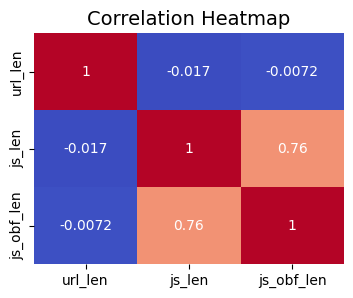

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df_spark.select(['url_len', 'js_len', 'js_obf_len']).toPandas().corr()

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()


###Distribution of js_len and js_ofs_len by labels

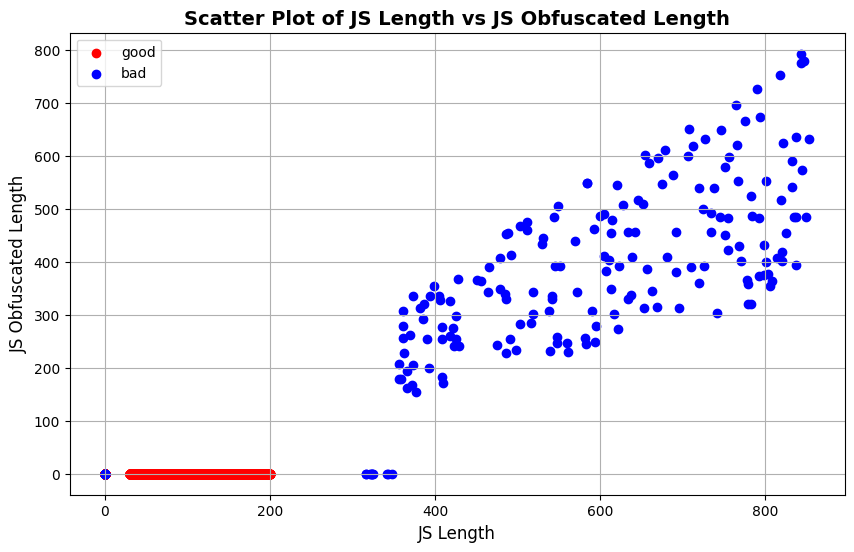

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Import necessary libraries and functions
import pyspark.sql.functions as F

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_spark.toPandas()

# Plot the scatter plot
plt.figure(figsize=(10, 6))

# Separate the data for 'good' and 'bad' labels
good_data = df_pandas[df_pandas['label'] == 'good']
bad_data = df_pandas[df_pandas['label'] == 'bad']

# Plot 'good' data points in red
plt.scatter(x=good_data['js_len'], y=good_data['js_obf_len'], c='red', label='good')

# Plot 'bad' data points in blue
plt.scatter(x=bad_data['js_len'], y=bad_data['js_obf_len'], c='blue', label='bad')

plt.title('Scatter Plot of JS Length vs JS Obfuscated Length', fontsize=14, fontweight='bold')
plt.xlabel('JS Length', fontsize=12)
plt.ylabel('JS Obfuscated Length', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')  # Place legend at upper right
plt.show()


In [ ]:
# Grouping the data by label and computing mean, median, min, and max values for 'js_len'
js_len_stats = df_spark.groupby("label").agg(
    F.mean("js_len").alias("mean_js_len"),
    F.expr("percentile_approx(js_len, 0.5)").alias("median_js_len"),
    F.min("js_len").alias("min_js_len"),
    F.max("js_len").alias("max_js_len")
)

# Showing the statistics for 'js_len'
js_len_stats.show()

# Grouping the data by label and computing mean, median, min, and max values for 'js_obf_len'
js_obf_len_stats = df_spark.groupby("label").agg(
    F.mean("js_obf_len").alias("mean_js_obf_len"),
    F.expr("percentile_approx(js_obf_len, 0.5)").alias("median_js_obf_len"),
    F.min("js_obf_len").alias("min_js_obf_len"),
    F.max("js_obf_len").alias("max_js_obf_len")
)

# Showing the statistics for 'js_obf_len'
js_obf_len_stats.show()


+-----+------------------+-------------+----------+----------+
|label|       mean_js_len|median_js_len|min_js_len|max_js_len|
+-----+------------------+-------------+----------+----------+
|  bad| 572.4092307692306|        593.1|       0.0|     853.2|
| good|109.01677715451301|        111.0|       0.0|     199.5|
+-----+------------------+-------------+----------+----------+

+-----+------------------+-----------------+--------------+--------------+
|label|   mean_js_obf_len|median_js_obf_len|min_js_obf_len|max_js_obf_len|
+-----+------------------+-----------------+--------------+--------------+
|  bad|368.86786153846157|           367.65|           0.0|       792.702|
| good|               0.0|              0.0|           0.0|           0.0|
+-----+------------------+-----------------+--------------+--------------+



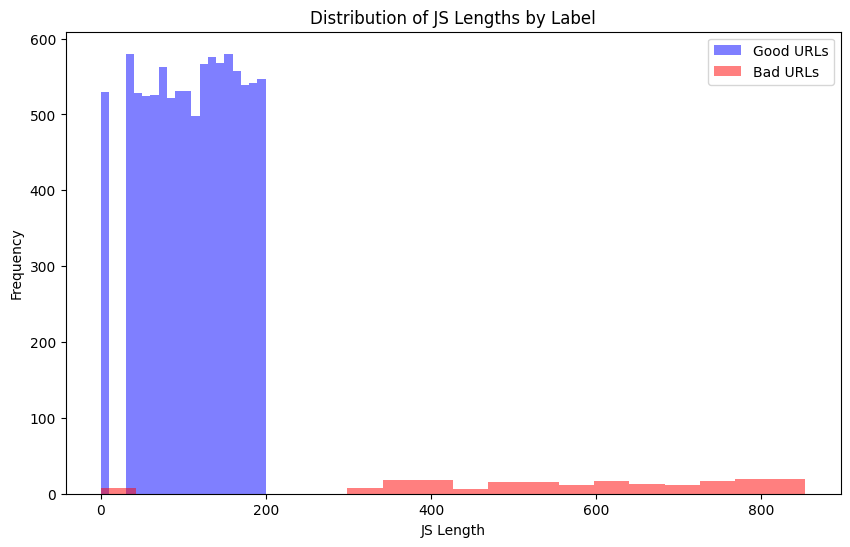

In [ ]:
label_stats = df_spark.groupby("label").agg(
    F.mean("js_len").alias("mean_js_len"),
    F.expr("percentile_approx(js_len, 0.5)").alias("median_js_len"),
    F.min("js_len").alias("min_js_len"),
    F.max("js_len").alias("max_js_len")
)

# Convert DataFrame to Pandas for visualization
label_stats_pd = label_stats.toPandas()


# Plotting histograms for URL lengths based on label
good_urls = df_spark.filter(df_spark.label == "good").select("js_len").rdd.flatMap(lambda x: x).collect()
bad_urls = df_spark.filter(df_spark.label != "good").select("js_len").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.hist(good_urls, bins=20, alpha=0.5, label='Good URLs', color='blue')
plt.hist(bad_urls, bins=20, alpha=0.5, label='Bad URLs', color='red')
plt.xlabel('JS Length')
plt.ylabel('Frequency')
plt.title('Distribution of JS Lengths by Label')
plt.legend(loc='upper right')
plt.show()

### Distribution of URL length by labels

In [ ]:
# Grouping the data by label and computing mean, median, min, and max URL lengths
label_stats = df_spark.groupby("label").agg(
    F.mean("url_len").alias("mean_url_len"),
    F.expr("percentile_approx(url_len, 0.5)").alias("median_url_len"),
    F.min("url_len").alias("min_url_len"),
    F.max("url_len").alias("max_url_len")
)

# Showing the statistics
label_stats.show()

+-----+-----------------+--------------+-----------+-----------+
|label|     mean_url_len|median_url_len|min_url_len|max_url_len|
+-----+-----------------+--------------+-----------+-----------+
|  bad|35.66153846153846|            32|         18|         76|
| good|35.75410504844467|            32|         14|        197|
+-----+-----------------+--------------+-----------+-----------+



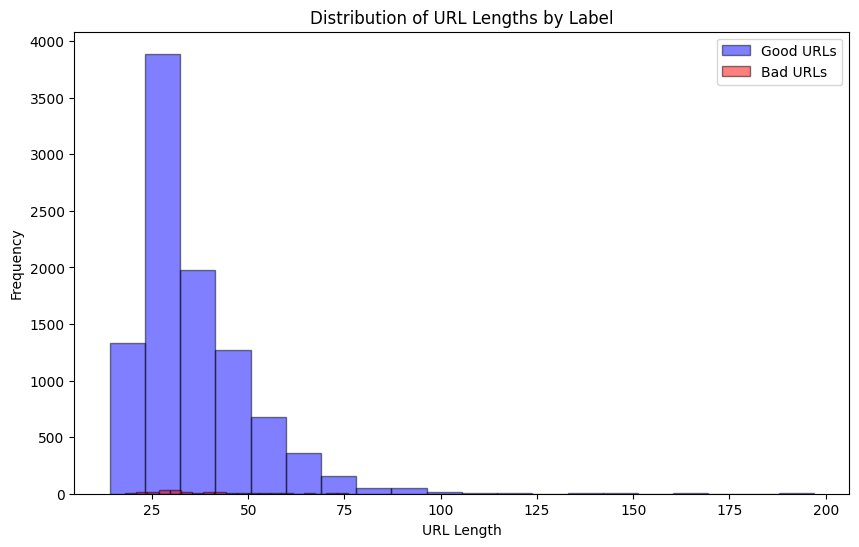

In [ ]:
# Grouping the data by label and computing mean, median, min, and max URL lengths
label_stats = df_spark.groupby("label").agg(
    F.mean("url_len").alias("mean_url_len"),
    F.expr("percentile_approx(url_len, 0.5)").alias("median_url_len"),
    F.min("url_len").alias("min_url_len"),
    F.max("url_len").alias("max_url_len")
)

# Convert DataFrame to Pandas for visualization
label_stats_pd = label_stats.toPandas()


# Plotting histograms for URL lengths based on label
good_urls = df_spark.filter(df_spark.label == "good").select("url_len").rdd.flatMap(lambda x: x).collect()
bad_urls = df_spark.filter(df_spark.label != "good").select("url_len").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.hist(good_urls, bins=20, alpha=0.5, label='Good URLs', color='blue',edgecolor='black')
plt.hist(bad_urls, bins=20, alpha=0.5, label='Bad URLs', color='red',edgecolor='black')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.title('Distribution of URL Lengths by Label')
plt.legend(loc='upper right')
plt.show()

# DATA PREPROCESSING





## DATA CLEANING

* **Finding Nulls**


---



In [ ]:
null_count = df_spark.filter(df_spark.url.isNull()).count()
print("Total number of null rows in url :", null_count)
null_count = df_spark.filter(df_spark.url_len.isNull()).count()
print("Total number of null rows in url_len :", null_count)
null_count = df_spark.filter(df_spark.ip_add.isNull()).count()
print("Total number of null rows in ip_add :", null_count)
null_count = df_spark.filter(df_spark.geo_loc.isNull()).count()
print("Total number of null rows in geo_loc :", null_count)
null_count = df_spark.filter(df_spark.tld.isNull()).count()
print("Total number of null rows in tld :", null_count)
null_count = df_spark.filter(df_spark.who_is.isNull()).count()
print("Total number of null rows in who_is :", null_count)
null_count = df_spark.filter(df_spark.https.isNull()).count()
print("Total number of null rows in https :", null_count)
null_count = df_spark.filter(df_spark.js_len.isNull()).count()
print("Total number of null rows in js_len :", null_count)
null_count = df_spark.filter(df_spark.js_obf_len.isNull()).count()
print("Total number of null rows in js_obf_len :", null_count)
null_count = df_spark.filter(df_spark.content.isNull()).count()
print("Total number of null rows in content :", null_count)
null_count = df_spark.filter(df_spark.label.isNull()).count()
print("Total number of null rows in label :", null_count)


24/05/06 23:35:03 WARN TaskSetManager: Stage 1 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:35:04 WARN TaskSetManager: Stage 4 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in url : 0


24/05/06 23:35:05 WARN TaskSetManager: Stage 7 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in url_len : 0


24/05/06 23:35:06 WARN TaskSetManager: Stage 10 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in ip_add : 0


24/05/06 23:35:07 WARN TaskSetManager: Stage 13 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in geo_loc : 0
Total number of null rows in tld : 0


24/05/06 23:35:07 WARN TaskSetManager: Stage 16 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:35:08 WARN TaskSetManager: Stage 19 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in who_is : 0


24/05/06 23:35:09 WARN TaskSetManager: Stage 22 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in https : 0
Total number of null rows in js_len : 0


24/05/06 23:35:10 WARN TaskSetManager: Stage 25 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in js_obf_len : 0


24/05/06 23:35:10 WARN TaskSetManager: Stage 28 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:35:11 WARN TaskSetManager: Stage 31 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Total number of null rows in content : 0
Total number of null rows in label : 0


* **Removing Null Value**


---



In [ ]:
df_spark=df_spark.na.drop()

## PROCESS DATA ACCRODING OUR MODEL

* **Changing the DataType of column js_len and js_obf_len from double to Integer**

---



In [ ]:
df_spark.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- url: string (nullable = true)
 |-- url_len: long (nullable = true)
 |-- ip_add: string (nullable = true)
 |-- geo_loc: string (nullable = true)
 |-- tld: string (nullable = true)
 |-- who_is: string (nullable = true)
 |-- https: string (nullable = true)
 |-- js_len: double (nullable = true)
 |-- js_obf_len: double (nullable = true)
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)



In [ ]:
df_spark = df_spark.withColumn("js_len", df_spark["js_len"].cast(IntegerType()))
df_spark = df_spark.withColumn("js_obf_len", df_spark["js_obf_len"].cast(IntegerType()))

In [ ]:
df_spark.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- url: string (nullable = true)
 |-- url_len: long (nullable = true)
 |-- ip_add: string (nullable = true)
 |-- geo_loc: string (nullable = true)
 |-- tld: string (nullable = true)
 |-- who_is: string (nullable = true)
 |-- https: string (nullable = true)
 |-- js_len: integer (nullable = true)
 |-- js_obf_len: integer (nullable = true)
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)



* **Tokenization (content)**

---



A Tokenizer is a transformer that takes an input string (e.g., a text column in a DataFrame) and splits it into words based on specified delimiters (usually whitespace).

In [ ]:
tokenizer = Tokenizer(outputCol="words")
tokenizer.setInputCol("content")

Tokenizer_8bc4726083a0

* **StopWords Removal (Content)**

---




creates a StopWordsRemover instance with the input column set to the output column of the previous Tokenizer transformation. It specifies the output column name as "contentVec", indicating that the resulting DataFrame will contain a new column with the tokenized text after stop words removal.

In [ ]:
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="contentVec")

In [ ]:
remover

StopWordsRemover_cd4abe10c202

* **Hashing TF (Text to numeric)**

---



HashingTF stands for Hashing Term Frequency, and it's a technique used to convert a collection of text documents into a numerical feature vector.

In [ ]:
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="rawFeatures", numFeatures=20)
hashingTF

HashingTF_181970f3b152

This code creates a HashingTF instance with the input column set to the output column of the previous StopWordsRemover transformation. It also specifies the output column name as "rawFeatures" and sets the numFeatures parameter to 20, indicating that the resulting feature vector will have a dimensionality of 20.

* **RegexTokenizer (URL)**

---



It  is similar to Tokenizer, but it allows you to specify a regular expression pattern to define how the input text should be tokenized.

In [ ]:
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="urlToken", pattern="/")

This code creates a RegexTokenizer instance with the input column set to "url" and the output column set to "urlToken". It specifies the regular expression pattern "/" to define how the input URL text should be tokenized. In this case, the tokenizer will split the URL string whenever it encounters a "/" character.

* **hashingTFurl**

---



it is used  to process tokenized URL data generated by a RegexTokenizer transformer.

In [ ]:
hashingTFurl = HashingTF(inputCol=regexTokenizer.getOutputCol(), outputCol="urlVec", numFeatures=20)


- inputCol: Specifies the input column from which the HashingTF transformer will read the tokenized URL data. It is set to the output column of the RegexTokenizer transformer, which contains the tokenized URL tokens (urlToken).
- outputCol: Specifies the name of the output column where the hashed URL features will be stored. Here, it's set to "urlVec".
- numFeatures: Determines the number of features (dimensions) in the output feature vector. It's set to 20 in this case, meaning the output feature vector will have a dimensionality of 20.

* **StringIndexer and OneHotEncoder transformers**

---



used  to encode categorical features into numerical representations.

In [ ]:
indexertld = StringIndexer(inputCol="tld", outputCol="tldIndex")
indexerlabels = StringIndexer(inputCol="label", outputCol="labelIndex")
indexerhttps= StringIndexer(inputCol="https", outputCol="httpsIndex")
indexerwhois= StringIndexer(inputCol="who_is", outputCol="whoisIndex")
Encodertld = OneHotEncoder(inputCols=[indexertld.getOutputCol()], outputCols=["tldVec"])
Encoderhttps = OneHotEncoder(inputCols=[indexerhttps.getOutputCol()], outputCols=["httpsVec"])
Encoderwhois = OneHotEncoder(inputCols=[indexerwhois.getOutputCol()], outputCols=["whoisVec"])


- StringIndexer:
  - StringIndexer is used to convert categorical strings into numerical indices.
  - You're setting up four StringIndexer instances: indexertld, indexerlabels, indexerhttps, and indexerwhois.
  - Each StringIndexer takes an input column (e.g., "tld", "label", "https", "who_is") and outputs a corresponding index column (e.g., "tldIndex", "labelIndex", "httpsIndex", "whoisIndex").
- OneHotEncoder:
  - OneHotEncoder is used to convert categorical indices into a sparse vector representation.
  - You're setting up three OneHotEncoder instances: Encodertld, Encoderhttps, and Encoderwhois.
  - Each OneHotEncoder takes the output column of the corresponding StringIndexer as input and outputs a sparse vector representation (e.g., "tldVec", "httpsVec", "whoisVec").

* **VectorAssembler**

---




It is used to combine multiple feature columns into a single feature vector column

In [ ]:
assembler = VectorAssembler(inputCols=["rawFeatures", "urlVec", "tldVec","httpsVec","whoisVec","js_len","js_obf_len"], outputCol="features")


## COMBINING ALL THE DATA PROCESSED

In [ ]:
pipeline = Pipeline(stages = [indexerlabels,tokenizer,remover,hashingTF,regexTokenizer,hashingTFurl,indexertld,indexerhttps,indexerwhois,Encodertld,Encoderhttps,Encoderwhois,assembler])
pipelineModel = pipeline.fit(df_spark)
df_spark = pipelineModel.transform(df_spark)

24/05/06 23:35:52 WARN TaskSetManager: Stage 34 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:35:53 WARN TaskSetManager: Stage 37 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:35:54 WARN TaskSetManager: Stage 40 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:35:54 WARN TaskSetManager: Stage 43 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
df_spark.show()

24/05/06 23:35:57 WARN TaskSetManager: Stage 46 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-------+---------------+-------------+---+----------+-----+------+----------+--------------------+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+----------+----------+----------------+-------------+-------------+--------------------+
|Unnamed: 0|                 url|url_len|         ip_add|      geo_loc|tld|    who_is|https|js_len|js_obf_len|             content|label|labelIndex|               words|          contentVec|         rawFeatures|            urlToken|              urlVec|tldIndex|httpsIndex|whoisIndex|          tldVec|     httpsVec|     whoisVec|            features|
+----------+--------------------+-------+---------------+-------------+---+----------+-----+------+----------+--------------------+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+----------+----------+--------------

24/05/06 23:36:01 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 46 (TID 136): Attempting to kill Python Worker


## FINALIZE OUR DATASET

In [ ]:
selected_Columns = ['labelIndex', 'features']
df_spark = df_spark.select(selected_Columns)
df_spark.show()

24/05/06 23:36:04 WARN TaskSetManager: Stage 47 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+
|labelIndex|            features|
+----------+--------------------+
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,5,6...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
+----------+--------------------+
only showing top 20 rows



24/05/06 23:36:08 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 47 (TID 137): Attempting to kill Python Worker


## SPLITTING THE DATA INTO TRAINING AND TESTING

In [ ]:
training_data, testing_data = df_spark.randomSplit([0.6805,0.3195], seed = 99999999)

In [ ]:
training_data.show()

24/05/06 23:36:14 WARN TaskSetManager: Stage 48 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+
|labelIndex|            features|
+----------+--------------------+
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
testing_data.show()

24/05/06 23:36:18 WARN TaskSetManager: Stage 49 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+
|labelIndex|            features|
+----------+--------------------+
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
|       0.0|(424,[0,1,2,3,4,5...|
+----------+--------------------+
only showing top 20 rows



# BUILT MODEL





## NaiveBayes Model

* **Fiting the Model on Traning Data**


---



In [ ]:
start=time.time()
# Create an instance of the NaiveBayes estimator
naive_bayes = NaiveBayes(labelCol="labelIndex", featuresCol="features", smoothing=1.0, modelType="multinomial" )

NaiveBayesModel = naive_bayes.fit(dataset=training_data)
end=time.time()
print("Time Taken to Fit the Model ", end-start)
NaiveBayes_TT=end-start

24/05/06 23:36:22 WARN TaskSetManager: Stage 50 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Time Taken to Fit the Model  2.52423095703125


* **Prediction**

---



In [ ]:
start1=time.time()
f_predictions = NaiveBayesModel.transform(testing_data)
# f_predictions.select('labelIndex','prediction').coalesce(1).write.option("header","true").csv('pred_output.csv')
end1=time.time()


In [ ]:
f_predictions.show()

24/05/06 23:36:40 WARN TaskSetManager: Stage 53 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+--------------------+--------------------+----------+
|labelIndex|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|       0.0|(424,[0,1,2,3,4,5...|[-800.27721217831...|[1.0,4.0911764381...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-667.86147558160...|[1.0,4.1896955241...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-1138.8548683399...|[1.0,7.0660015021...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-425.64067877191...|[1.0,2.8277461896...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-1024.5633174077...|[1.0,1.6765499580...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-569.51372060796...|[1.0,3.9698792427...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-462.89802646983...|[1.0,1.2071210221...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-719.57095307482...|[1.0,5.2839049210...|       0.0|
|       0.0|(424,[0,1,2,3,4,5...|[-766.7401

24/05/06 23:36:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/06 23:36:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


* **Evaluation**

---



In [ ]:
# Define a MulticlassClassificationEvaluator for accuracy
evaluation_accuracy = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute accuracy
NaiveBayes_accuracy = evaluation_accuracy.evaluate(f_predictions, {evaluation_accuracy.metricName: "accuracy"})
print("Accuracy:", NaiveBayes_accuracy)

24/05/06 23:36:44 WARN TaskSetManager: Stage 54 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.9976138147566719


In [ ]:
# Define a MulticlassClassificationEvaluator for recall
evaluation_recall = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute recall
NaiveBayes_recall = evaluation_recall.evaluate(f_predictions, {evaluation_recall.metricName: "weightedRecall"})
print("Recall:", NaiveBayes_recall)

24/05/06 23:37:06 WARN TaskSetManager: Stage 56 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Recall: 0.9976138147566719


In [ ]:
# Compute F1 score
evaluation_f1 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute F1 score
NaiveBayes_f1_score = evaluation_f1.evaluate(f_predictions, {evaluation_f1.metricName: "f1"})
print("F1 Score:", NaiveBayes_f1_score)


24/05/06 23:37:10 WARN TaskSetManager: Stage 58 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


F1 Score: 0.9975437568541727


* **confusion Matrix**

---



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
pred_pd = f_predictions.select("labelIndex", "prediction").toPandas()
# Genrate Confusion Matrix
# Define the labels
labels = pred_pd["labelIndex"].unique()

pd.DataFrame(confusion_matrix(pred_pd["labelIndex"], pred_pd["prediction"],labels=labels), index=["P_good","P_bad"], columns=["A_good","A_bad"])

24/05/06 23:37:25 WARN TaskSetManager: Stage 60 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


,A_good,A_bad
P_good,15589,0
P_bad,38,298


## LinearSVC

* **Fitting the Model**

---



In [ ]:
Linearsvc = LinearSVC(labelCol="labelIndex", featuresCol="features", maxIter=100)
start=time.time()
LinearSVCModel = Linearsvc.fit(training_data)
end=time.time()

print("Time to train:")
print(end-start)
LinearSVC_TT=end-start

24/05/06 23:37:29 WARN TaskSetManager: Stage 61 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:37:34 WARN TaskSetManager: Stage 63 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:37:37 WARN TaskSetManager: Stage 65 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:37:37 WARN TaskSetManager: Stage 67 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:37:37 WARN TaskSetManager: Stage 69 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:37:38 WARN TaskSetManager: Stage 71 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:37:38 WARN TaskSetManager: Stage 73 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.

Time to train:
39.88803195953369


* **Prediction**

---



In [ ]:
start1=time.time()
Linear_SVC_pred = LinearSVCModel.transform(testing_data)
end1=time.time()
print("Time to predict:")
print(end1-start1)

Time to predict:
0.033547163009643555


* **Evaluation**

---



In [ ]:
# Define a MulticlassClassificationEvaluator for accuracy
evaluation_accuracy = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute accuracy
LinearSVC_accuracy = evaluation_accuracy.evaluate(Linear_SVC_pred, {evaluation_accuracy.metricName: "accuracy"})
print("Accuracy:",LinearSVC_accuracy)

24/05/06 23:38:39 WARN TaskSetManager: Stage 565 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.9982417582417582


In [ ]:
# Define a MulticlassClassificationEvaluator for recall
evaluation_recall = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute recall
LinearSVC_recall = evaluation_recall.evaluate(Linear_SVC_pred, {evaluation_recall.metricName: "weightedRecall"})
print("Recall:",LinearSVC_recall)

24/05/06 23:38:44 WARN TaskSetManager: Stage 567 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Recall: 0.9982417582417582


In [ ]:
# Compute F1 score
evaluation_f1 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute F1 score
LinearSVC_f1_score = evaluation_f1.evaluate(Linear_SVC_pred, {evaluation_f1.metricName: "f1"})
print("F1 Score:", LinearSVC_f1_score)


24/05/06 23:38:47 WARN TaskSetManager: Stage 569 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


F1 Score: 0.9982126232741617


* **confusion Matrix**
---

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
pred_pd = Linear_SVC_pred.select("labelIndex", "prediction").toPandas()
# Genrate Confusion Matrix
# Define the labels
labels = pred_pd["labelIndex"].unique()

pd.DataFrame(confusion_matrix(pred_pd["labelIndex"], pred_pd["prediction"],labels=labels), index=["P_good","P_bad"], columns=["A_good","A_bad"])

24/05/06 23:38:51 WARN TaskSetManager: Stage 571 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


,A_good,A_bad
P_good,15586,3
P_bad,25,311


## Decison Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

* **Fitting the Model**
---

In [ ]:
# Define the Decision Tree classifier
tree = DecisionTreeClassifier(featuresCol='features', labelCol='labelIndex',  impurity='entropy',seed=10)


start=time.time()
tree_model = tree.fit(training_data)
end=time.time()

print("Time to train:")
print(end-start)
Decison_Tree_TT=end-start

24/05/06 23:38:58 WARN TaskSetManager: Stage 572 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:38:59 WARN TaskSetManager: Stage 573 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:39:01 WARN TaskSetManager: Stage 574 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:39:05 WARN TaskSetManager: Stage 576 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:39:09 WARN TaskSetManager: Stage 578 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:39:09 WARN TaskSetManager: Stage 580 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:39:10 WARN TaskSetManager: Stage 582 contains a task of very large size (10434 KiB). The maximum recommended task size is 10

Time to train:
11.599788904190063


24/05/06 23:39:10 WARN TaskSetManager: Stage 584 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


* **Prediction**

---



In [ ]:
start1=time.time()
# Make predictions on the test data
tree_predictions = tree_model.transform(testing_data)
end1=time.time()
print("Time to predict:")
print(end1-start1)

Time to predict:
0.06037306785583496


* **Evaluation**
-----

In [ ]:
# Define a MulticlassClassificationEvaluator for accuracy
evaluation_accuracy = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute accuracy
Decison_Tree_accuracy = evaluation_accuracy.evaluate(tree_predictions, {evaluation_accuracy.metricName: "accuracy"})
print("Accuracy:", Decison_Tree_accuracy)

24/05/06 23:39:16 WARN TaskSetManager: Stage 586 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.9991836734693877


In [ ]:
# Define a MulticlassClassificationEvaluator for recall
evaluation_recall = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute recall
Decison_Tree_recall = evaluation_recall.evaluate(tree_predictions, {evaluation_recall.metricName: "weightedRecall"})
print("Recall:", Decison_Tree_recall)

24/05/06 23:39:18 WARN TaskSetManager: Stage 588 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Recall: 0.9991836734693877


In [ ]:
# Compute F1 score
evaluation_f1 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute F1 score
Decison_Tree_f1_score = evaluation_f1.evaluate(tree_predictions, {evaluation_f1.metricName: "f1"})
print("F1 Score:", Decison_Tree_f1_score)


24/05/06 23:39:20 WARN TaskSetManager: Stage 590 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


F1 Score: 0.9991830782693485


* **confusion Matrix**
---

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
pred_pd = tree_predictions.select("labelIndex", "prediction").toPandas()
# Genrate Confusion Matrix
# Define the labels
labels = pred_pd["labelIndex"].unique()

pd.DataFrame(confusion_matrix(pred_pd["labelIndex"], pred_pd["prediction"],labels=labels), index=["P_good","P_bad"], columns=["A_good","A_bad"])

24/05/06 23:39:22 WARN TaskSetManager: Stage 592 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


,A_good,A_bad
P_good,15583,6
P_bad,7,329


## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
import time


* **Fitting the Model**
---

In [ ]:
# Define the Random Forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='labelIndex', impurity='entropy', seed=10)

start=time.time()
rf_model = rf.fit(training_data)
end=time.time()

print("Time to train:")
print(end-start)
Random_Forest_TT=end-start

24/05/06 23:40:49 WARN TaskSetManager: Stage 607 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:40:50 WARN TaskSetManager: Stage 608 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:40:53 WARN TaskSetManager: Stage 609 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:40:56 WARN TaskSetManager: Stage 611 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:40:59 WARN TaskSetManager: Stage 613 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:00 WARN TaskSetManager: Stage 615 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:00 WARN TaskSetManager: Stage 617 contains a task of very large size (10434 KiB). The maximum recommended task size is 10

Time to train:
11.87963080406189


* **Prediction**
---

In [ ]:
start1=time.time()
rf_model = rf_model.transform(testing_data)
end1=time.time()
print("Time to predict:")
print(end1-start1)

Time to predict:
0.06789612770080566


* **Evaluation**
---

In [ ]:
# Define a MulticlassClassificationEvaluator for accuracy
evaluation_accuracy = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute accuracy
Random_Forest_accuracy = evaluation_accuracy.evaluate(rf_model, {evaluation_accuracy.metricName: "accuracy"})
print("Accuracy:", Random_Forest_accuracy)

24/05/06 23:41:15 WARN TaskSetManager: Stage 621 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.9980533751962324


In [ ]:
# Define a MulticlassClassificationEvaluator for recall
evaluation_recall = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute recall
Random_Forest_recall = evaluation_recall.evaluate(rf_model, {evaluation_recall.metricName: "weightedRecall"})
print("Recall:", Random_Forest_recall)

24/05/06 23:41:21 WARN TaskSetManager: Stage 623 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Recall: 0.9980533751962323


In [ ]:
# Compute F1 score
evaluation_f1 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute F1 score
Random_Forest_f1_score = evaluation_f1.evaluate(rf_model, {evaluation_f1.metricName: "f1"})
print("F1 Score:", Random_Forest_f1_score)


24/05/06 23:41:27 WARN TaskSetManager: Stage 625 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


F1 Score: 0.9980072707199633


* **confusion Matrix**
---

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
pred_pd = rf_model.select("labelIndex", "prediction").toPandas()
# Genrate Confusion Matrix
# Define the labels
labels = pred_pd["labelIndex"].unique()

pd.DataFrame(confusion_matrix(pred_pd["labelIndex"], pred_pd["prediction"],labels=labels), index=["P_good","P_bad"], columns=["A_good","A_bad"])

24/05/06 23:41:30 WARN TaskSetManager: Stage 627 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


,A_good,A_bad
P_good,15589,0
P_bad,31,305


## Gradient Boosting  Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

* **Fitting the Model**
---

In [ ]:
# Define the GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='labelIndex', maxIter=10)
start=time.time()
gbt_model = gbt.fit(training_data)
end=time.time()

print("Time to train:")
print(end-start)
Gradient_Boosting_TT=end-start

24/05/06 23:41:33 WARN TaskSetManager: Stage 628 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:34 WARN TaskSetManager: Stage 629 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:37 WARN TaskSetManager: Stage 630 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:41 WARN TaskSetManager: Stage 632 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:44 WARN TaskSetManager: Stage 634 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:44 WARN TaskSetManager: Stage 636 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 23:41:44 WARN TaskSetManager: Stage 638 contains a task of very large size (10434 KiB). The maximum recommended task size is 10

Time to train:
18.127641916275024


* **Prediction**
---

In [ ]:
start1=time.time()
gbt_predictions = gbt_model.transform(training_data)
end1=time.time()
print("Time to predict:")
print(end1-start1)

Time to predict:
0.051078081130981445


* **Evaluation**
---

In [ ]:
# Define a MulticlassClassificationEvaluator for accuracy
evaluation_accuracy = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute accuracy
Gradient_Boosting_accuracy = evaluation_accuracy.evaluate(gbt_predictions, {evaluation_accuracy.metricName: "accuracy"})
print("Accuracy:",LinearSVC_accuracy)

24/05/06 23:41:56 WARN TaskSetManager: Stage 732 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.9982417582417582


In [ ]:
# Define a MulticlassClassificationEvaluator for recall
evaluation_recall = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute recall
Gradient_Boosting_recall = evaluation_recall.evaluate(gbt_predictions, {evaluation_recall.metricName: "weightedRecall"})
print("Recall:", Gradient_Boosting_recall)

24/05/06 23:41:58 WARN TaskSetManager: Stage 734 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


Recall: 0.9996771826852532


In [ ]:
# Compute F1 score
evaluation_f1 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Compute F1 score
Gradient_Boosting_f1_score = evaluation_f1.evaluate(gbt_predictions, {evaluation_f1.metricName: "f1"})
print("F1 Score:", Gradient_Boosting_f1_score)


24/05/06 23:42:00 WARN TaskSetManager: Stage 736 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


F1 Score: 0.9996760185124074


* **confusion Matrix**
---

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
pred_pd = gbt_predictions.select("labelIndex", "prediction").toPandas()
# Genrate Confusion Matrix
# Define the labels
labels = pred_pd["labelIndex"].unique()

pd.DataFrame(confusion_matrix(pred_pd["labelIndex"], pred_pd["prediction"],labels=labels), index=["P_good","P_bad"], columns=["A_good","A_bad"])

24/05/06 23:42:04 WARN TaskSetManager: Stage 738 contains a task of very large size (10434 KiB). The maximum recommended task size is 1000 KiB.


,A_good,A_bad
P_good,33324,0
P_bad,11,740


# COMPARISON OF ALL ACCURACY OF OUR MODEL





In [ ]:
model = ['NAIVE BAYES','LinearSVC', 'DECISION TREE','RANDOM FOREST',"Gradient Boosting"]
accuracy=[NaiveBayes_accuracy,LinearSVC_accuracy,Decison_Tree_accuracy,Random_Forest_accuracy,Gradient_Boosting_accuracy]
recall=[NaiveBayes_recall,LinearSVC_recall,Decison_Tree_recall,Random_Forest_recall,Gradient_Boosting_recall]
f1_score=[NaiveBayes_f1_score,LinearSVC_f1_score,Decison_Tree_f1_score,Random_Forest_f1_score,Gradient_Boosting_f1_score]
Time_Taken=[NaiveBayes_TT,LinearSVC_TT,Decison_Tree_TT,Random_Forest_TT,Gradient_Boosting_TT]

data = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'F1 Score': f1_score,'Time_Taken':Time_Taken}, index=model)
data


,Accuracy,Recall,F1 Score,Time_Taken
NAIVE BAYES,0.997614,0.997614,0.997544,2.524231
LinearSVC,0.998242,0.998242,0.998213,39.888032
DECISION TREE,0.999184,0.999184,0.999183,11.599789
RANDOM FOREST,0.998053,0.998053,0.998007,11.879631
Gradient Boosting,0.999677,0.999677,0.999676,18.127642


<Axes: ylabel='Accuracy'>

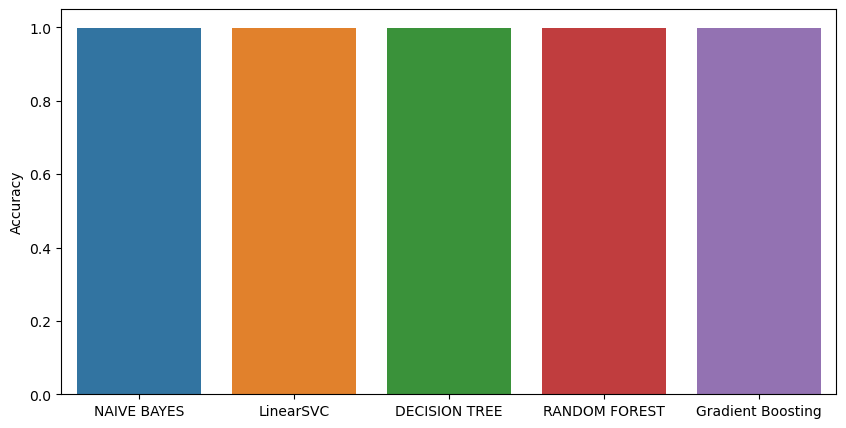

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=data, y='Accuracy', x=data.index)